In [4]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter

from gensim.models.word2vec import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

label1 = pd.read_csv('../data/preliminary_train_label_dataset.csv')
label2 = pd.read_csv('../data/preliminary_train_label_dataset_s.csv')
label_df = pd.concat([label1, label2]).reset_index(drop=True)
label_df = label_df.drop_duplicates().reset_index(drop=True)

submit_df = pd.read_csv('../data/preliminary_submit_dataset_b.csv')

print(label_df.shape, submit_df.shape)

log_df = pd.read_csv('../code/log_template.csv')
log_df['msg_lower'] = log_df['msg_lower'].astype(str)
log_df['server_model'] = log_df['server_model'].astype(str)

log_df['time'] = pd.to_datetime(log_df['time'])
label_df['fault_time'] = pd.to_datetime(label_df['fault_time'])
submit_df['fault_time'] = pd.to_datetime(submit_df['fault_time'])

log_df['time_ts'] = log_df["time"].values.astype(np.int64) // 10 ** 9
label_df['fault_time_ts'] = label_df["fault_time"].values.astype(np.int64) // 10 ** 9
submit_df['fault_time_ts'] = submit_df["fault_time"].values.astype(np.int64) // 10 ** 9

crashdump_df = pd.read_csv('../data/preliminary_crashdump_dataset.csv')
venus_df = pd.read_csv('../data/preliminary_venus_dataset.csv')
crashdump_df['fault_time'] = pd.to_datetime(crashdump_df['fault_time'])
venus_df['fault_time'] = pd.to_datetime(venus_df['fault_time'])
crashdump_df['fault_time_ts'] = crashdump_df["fault_time"].values.astype(np.int64) // 10 ** 9
venus_df['fault_time_ts'] = venus_df["fault_time"].values.astype(np.int64) // 10 ** 9

label_df = label_df.merge(log_df[['sn', 'server_model']].drop_duplicates(), on=['sn'], how='left')
submit_df = submit_df.merge(log_df[['sn', 'server_model']].drop_duplicates(), on=['sn'], how='left')
label_df = label_df.fillna('MISSING')
submit_df = submit_df.fillna('MISSING')
print(label_df.shape, submit_df.shape)

(16604, 3) (3030, 2)
(16604, 5) (3030, 4)


In [9]:
def safe_split(strs, n, sep='|'):
    str_li = strs.split(sep)
    if len(str_li) >= n + 1:
        return str_li[n].strip()
    else:
        return ''

In [13]:
log_df['msg_split_0'] = log_df['msg_lower'].apply(lambda x: safe_split(x, 0))

In [14]:
log_df['msg_split_1'] = log_df['msg_lower'].apply(lambda x: safe_split(x, 1))

In [15]:
log_df['msg_split_2'] = log_df['msg_lower'].apply(lambda x: safe_split(x, 2))

In [1]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter

from gensim.models.word2vec import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

label1 = pd.read_csv('../data/preliminary_train_label_dataset.csv')
label2 = pd.read_csv('../data/preliminary_train_label_dataset_s.csv')
label_df = pd.concat([label1, label2]).reset_index(drop=True)
label_df = label_df.drop_duplicates().reset_index(drop=True)

submit_df = pd.read_csv('../data/preliminary_submit_dataset_b.csv')

print(label_df.shape, submit_df.shape)

log_df = pd.read_csv('../code/log_template.csv')
log_df['msg_lower'] = log_df['msg_lower'].astype(str)
log_df['server_model'] = log_df['server_model'].astype(str)

log_df['time'] = pd.to_datetime(log_df['time'])
label_df['fault_time'] = pd.to_datetime(label_df['fault_time'])
submit_df['fault_time'] = pd.to_datetime(submit_df['fault_time'])

log_df['time_ts'] = log_df["time"].values.astype(np.int64) // 10 ** 9
label_df['fault_time_ts'] = label_df["fault_time"].values.astype(np.int64) // 10 ** 9
submit_df['fault_time_ts'] = submit_df["fault_time"].values.astype(np.int64) // 10 ** 9

crashdump_df = pd.read_csv('../data/preliminary_crashdump_dataset.csv')
venus_df = pd.read_csv('../data/preliminary_venus_dataset.csv')
crashdump_df['fault_time'] = pd.to_datetime(crashdump_df['fault_time'])
venus_df['fault_time'] = pd.to_datetime(venus_df['fault_time'])
crashdump_df['fault_time_ts'] = crashdump_df["fault_time"].values.astype(np.int64) // 10 ** 9
venus_df['fault_time_ts'] = venus_df["fault_time"].values.astype(np.int64) // 10 ** 9

label_df = label_df.merge(log_df[['sn', 'server_model']].drop_duplicates(), on=['sn'], how='left')
submit_df = submit_df.merge(log_df[['sn', 'server_model']].drop_duplicates(), on=['sn'], how='left')
label_df = label_df.fillna('MISSING')
submit_df = submit_df.fillna('MISSING')
print(label_df.shape, submit_df.shape)

(16604, 3) (3030, 2)
(16604, 5) (3030, 4)


In [33]:
cnt_list1 = []
cnt_list2 = []
for idx in tqdm(range(label_df.shape[0])):
    row = label_df.iloc[idx]
    sn = row['sn']
    fault_time = row['fault_time']
    fault_time_ts = row['fault_time_ts']
    server_model = row['server_model']
    label = row['label']
    if label > 1:
        continue
    
    sub_log1 = log_df[(log_df['sn'] == sn) & (log_df['time_ts'] <= fault_time_ts)]
    sub_log1 = sub_log1.tail(50)
    sub_log1 = sub_log1.sort_values(by='time')
    
    if label == 0:
        cnt_list1.append(sub_log1[(~(sub_log1['msg_lower'].str.startswith('system'))) &\
                                  (~(sub_log1['msg_lower'].str.startswith('processor')))].shape[0])
    if label == 1:
        cnt_list2.append(sub_log1[(~(sub_log1['msg_lower'].str.startswith('system'))) &\
                                  (~(sub_log1['msg_lower'].str.startswith('processor')))].shape[0])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16604/16604 [03:06<00:00, 89.04it/s]


/data/projects/log-based-failuer-diagnosis-main/env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/projects/log-based-failuer-diagnosis-main/env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

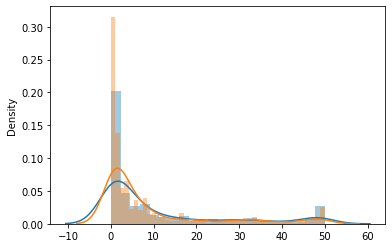

In [34]:
sns.distplot(cnt_list1)
sns.distplot(cnt_list2)

In [38]:
df_train = df_train[df_train['second_span_2h'] < 10000]

/data/projects/log-based-failuer-diagnosis-main/env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/projects/log-based-failuer-diagnosis-main/env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='processor_nunique', ylabel='Density'>

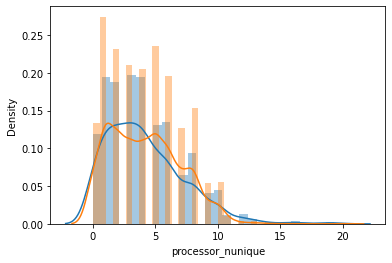

In [5]:
sns.distplot(df_train[df_train['label'] == 0]['processor_nunique'])
sns.distplot(df_train[df_train['label'] == 1]['processor_nunique'])

In [2]:
cnt_list = []
span_list = []
for idx in tqdm(range(label_df.shape[0])):
    row = label_df.iloc[idx]
    sn = row['sn']
    fault_time = row['fault_time']
    fault_time_ts = row['fault_time_ts']
    server_model = row['server_model']
    
    sub_log2 = log_df[(log_df['sn'] == sn) & (log_df['time_ts'] >= fault_time_ts)]
    sub_log2 = sub_log2.sort_values(by='time')
    cnt_list.append(sub_log2.shape[0])
    
    if sub_log2.shape[0] > 0:
        span_list.append(sub_log2.iloc[0]['time_ts'] - fault_time_ts)
    else:
        span_list.append(0)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16604/16604 [10:12<00:00, 27.11it/s]


In [2]:
dtype = {
    'server_model': 'str',
    'last_msg_id': 'str',
    'last_template_id': 'str',
    'tmp_appearance_1': 'str',
    'tmp_appearance_2': 'str',
    'tmp_appearance_3': 'str',
    'msg_appearance_1': 'str',
    'msg_appearance_2': 'str',
    'msg_appearance_3': 'str',
    'max_continuous_msg': 'str'
}
df_train = pd.read_csv('../code/train.csv', dtype=dtype)
df_test = pd.read_csv('../code/test.csv', dtype=dtype)

In [4]:
df_train['post_cnt'] = cnt_list
df_train['post_span'] = span_list

In [13]:
df_train[df_train['label'] == 1]

,sn,fault_time,server_model,last_msg_id,last_template_id,cnt_2h,percent_2h,msg_nunique_2h,template_nunique_2h,msg_percent_2h,...,tfv_11,tfv_12,tfv_13,tfv_14,tfv_15,crashdump_cnt,venus_cnt,label,post_cnt,post_span
1122,SERVER_12,2020-06-11 11:45:00,SM3,3,4,20,0.555556,10,8,0.500000,...,0.027940,-0.002537,-0.039212,0.035598,0.022161,0,0,1,127,10108374
1146,SERVER_588,2020-03-19 05:33:00,SM6,40,3,20,0.152672,5,4,0.250000,...,0.105329,-0.015719,-0.059050,0.021905,0.053710,0,0,1,1,38
1150,SERVER_437,2020-01-25 05:14:00,SM6,40,3,20,0.444444,5,5,0.250000,...,0.101827,-0.016031,-0.057791,0.016409,0.054206,0,0,1,1,15953037
1155,SERVER_567,2020-07-22 06:08:00,SM6,63,3,20,0.408163,10,5,0.500000,...,0.252862,-0.026811,-0.054421,-0.030950,0.053296,0,0,1,212,152557
1162,SERVER_742,2020-07-23 12:47:00,SM6,44,4,20,0.100503,6,6,0.300000,...,0.031872,-0.008087,-0.001633,-0.003949,0.016663,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16505,SERVER_25153,2020-01-26 05:32:00,SM103,219,1,6,1.000000,4,4,0.666667,...,-0.020619,-0.029800,0.010254,0.058465,0.021697,0,0,1,0,0
16522,SERVER_737,2020-04-21 11:32:00,SM5,101,2,3,1.000000,3,2,1.000000,...,-0.005538,-0.012617,-0.007139,-0.006633,0.029630,0,0,1,0,0
16524,SERVER_17042,2020-05-29 09:41:00,SM34,213,80,5,1.000000,4,3,0.800000,...,0.010265,-0.002381,0.034449,0.039888,0.019755,0,0,1,0,0
16535,SERVER_14848,2020-01-05 16:18:00,SM14,192,41,1,1.000000,1,1,1.000000,...,-0.004726,-0.005862,-0.000592,0.000343,0.006991,0,0,1,0,0


In [11]:
df_train[df_train['label'] == 0]

,sn,fault_time,server_model,last_msg_id,last_template_id,cnt_2h,percent_2h,msg_nunique_2h,template_nunique_2h,msg_percent_2h,...,tfv_11,tfv_12,tfv_13,tfv_14,tfv_15,crashdump_cnt,venus_cnt,label,post_cnt,post_span
0,SERVER_25698,2020-10-09 13:43:00,SM0,0,1,20,0.076923,1,1,0.05,...,0.006188,0.004494,-0.007211,-0.029983,-0.000066,0,0,0,0,0
1,SERVER_25699,2020-08-25 18:50:00,SM3,5,3,20,0.952381,9,8,0.45,...,0.024321,-0.003542,-0.035807,0.030520,0.023102,0,0,0,0,0
2,SERVER_25712,2020-03-16 13:20:00,SM4,3,4,20,0.238095,12,8,0.60,...,0.023686,-0.004972,-0.022471,0.023828,0.013383,0,0,0,0,0
3,SERVER_25708,2020-07-25 12:44:00,SM4,25,16,20,0.066225,2,2,0.10,...,0.004866,-0.005059,0.012442,-0.002809,-0.001592,0,0,0,0,0
4,SERVER_25711,2020-03-16 16:51:00,SM4,3,4,20,0.196078,8,7,0.40,...,0.025873,-0.002876,-0.020622,0.022176,0.013796,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16502,SERVER_27674,2020-07-04 16:58:00,SM103,220,1,3,1.000000,3,3,1.00,...,-0.014202,-0.052599,0.000740,0.229986,0.091953,0,0,0,0,0
16507,SERVER_27679,2020-08-24 08:41:00,SM103,968,176,4,1.000000,4,4,1.00,...,-0.005901,-0.005488,-0.007512,0.040658,0.020657,0,0,0,0,0
16509,SERVER_27659,2020-08-10 16:12:00,SM103,265,100,3,1.000000,3,3,1.00,...,-0.002180,-0.003510,0.011805,0.028328,0.017545,0,0,0,0,0
16513,SERVER_27680,2020-06-16 18:21:00,SM103,265,100,3,1.000000,3,3,1.00,...,-0.002180,-0.003510,0.011805,0.028328,0.017545,0,0,0,0,0


In [15]:
log_df[log_df['sn'] == 'SERVER_737']

,sn,time,msg,server_model,msg_lower,msg_id,template_id,template,time_ts
482142,SERVER_737,2020-04-21 11:12:11,Processor CPU1 Status | Uncorrectable machine...,SM5,processor cpu1 status | uncorrectable machine ...,49,2,processor <:*:> <:*:> | uncorrectable machine ...,1587467531
482148,SERVER_737,2020-04-21 11:12:36,Processor CPU1 Status | Uncorrectable machine...,SM5,processor cpu1 status | uncorrectable machine ...,101,2,processor <:*:> <:*:> | uncorrectable machine ...,1587467556
482152,SERVER_737,2020-04-21 11:12:35,System Boot Initiated SysRestart | System Res...,SM5,system boot initiated sysrestart | system rest...,44,4,system <:*:> <:*:> <:*:> | <:*:> <:*:> | asserted,1587467555


In [21]:
log_df[log_df['msg_lower'].str.startswith('system boot initiated')]

sn              28032
time            28032
msg             28032
server_model    28032
msg_lower       28032
msg_id          28032
template_id     28032
template        28032
time_ts         28032
dtype: int64

In [1]:
import pandas as pd

In [2]:
dtype = {
    'server_model': 'str',
    'last_msg_id': 'str',
    'last_template_id': 'str',
    'tmp_appearance_1': 'str',
    'tmp_appearance_2': 'str',
    'tmp_appearance_3': 'str',
    'msg_appearance_1': 'str',
    'msg_appearance_2': 'str',
    'msg_appearance_3': 'str',
    'max_continuous_msg': 'str'
}
df_train = pd.read_csv('../code/train.csv', dtype=dtype)
df_test = pd.read_csv('../code/test.csv', dtype=dtype)

In [4]:
import seaborn as sns

In [18]:
df_train = df_train[df_train['second_span_2h'] < 100000]

/data/projects/log-based-failuer-diagnosis-main/env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/data/projects/log-based-failuer-diagnosis-main/env/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

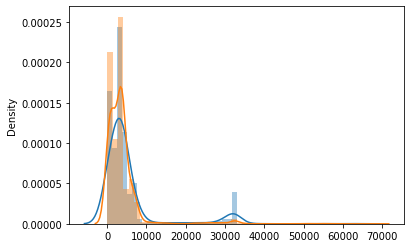

In [24]:
sns.distplot(df_train[df_train['label'] == 0]['second_span_2h'].values)
sns.distplot(df_train[df_train['label'] == 1]['second_span_2h'].values)